# exp012

In [3]:
import os
import pickle
from joblib import dump, load
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
import xgboost as xgb

sns.set_style("darkgrid")
%matplotlib inline

## 実験設定

In [4]:
class CONFIG:
    seed = 42
    n_splits = 5
    num_boost_round = 10000
    early_stopping_rounds = 10
    learning_rate = 0.01
    objective = "regression"
    num_leaves = 32
    max_depth_xgb = 6
    max_depth_rf = 15
    period = 1000
    n_estimators = 1000
    exp_id = "012"
    model_path = Path(f"../output/model{exp_id}")
    model_path.mkdir(parents=True, exist_ok=True)
    submission_path = Path(f"../output/submission")

In [5]:
input_path = Path("../input")

train_df = pd.read_parquet(input_path / "train.parquet")
test_df = pd.read_parquet(input_path / "test.parquet")

## RMSLEの定義

In [6]:
def feval_rmsle(preds, data):
    y_true = data.get_label()
    preds = np.clip(preds, 0, None)  # 0より小さい値を0に置換
    rmsle = np.sqrt(mean_squared_log_error(y_true, preds))
    return 'RMSLE', rmsle, False

## 特徴量エンジニアリング

In [7]:
df = pd.concat([train_df, test_df], axis=0, sort=False).reset_index(drop=True)
df = df.drop(["casual", "registered"], axis=1)

In [8]:
datetime = pd.to_datetime(df["datetime"])
df["year"] = datetime.dt.year
df["month"] = datetime.dt.month
df["day"] = datetime.dt.day
df["hour"] = datetime.dt.hour
df["dayofweek"] = datetime.dt.day_name()
df["dayofweek"] = df["dayofweek"].map({"Monday": 0, "Tuesday": 1, "Wednesday": 2, "Thursday": 3, "Friday": 4, "Saturday": 5, "Sunday": 6})
df = df.drop("datetime", axis=1)

In [9]:
df["count"] = df["count"].apply(lambda x: np.log(x))

In [10]:
df['peak'] = df[['hour', 'workingday']].apply(lambda x: 1 if (x['workingday'] == 1 and (x['hour'] == 8 or 17 <= x['hour'] <= 18  or 12 <= x['hour'] <= 13)) \
                                        or (x['workingday'] == 0 and 10 <= x['hour'] <= 19) else 0, axis=1)

In [11]:
agg_numeric_feature = ["temp", "atemp", "humidity", "windspeed"]
function = ["std", "mean", "max"]

for col in agg_numeric_feature:
    for func in function:
        agg_df = df.groupby("hour").agg({col: func}).reset_index().rename(columns={col: f"{col}_{func}"})
        df = df.merge(agg_df, on="hour", how="left")

In [12]:
train_df = df[~df["count"].isnull()].reset_index(drop=True)
test_df = df[df["count"].isnull()].drop("count", axis=1).reset_index(drop=True)

## LightGBM train

In [13]:
def lgb_train(df, model_path):
    kf = KFold(n_splits=CONFIG.n_splits, shuffle=True, random_state=CONFIG.seed)
    fold_rmsles = []

    for fold, (train_index, valid_index) in enumerate(kf.split(df)):
        print(f"start training for fold {fold}")

        X_train = df.iloc[train_index].drop(["count"], axis=1)
        y_train = df.iloc[train_index]["count"]

        X_valid = df.iloc[valid_index].drop(["count"], axis=1)
        y_valid = df.iloc[valid_index]["count"]

        print("start training")
        params = {
            "objective": CONFIG.objective,
            "seed": CONFIG.seed,
            "learning_rate": CONFIG.learning_rate,
            "num_leaves": CONFIG.num_leaves,
        }

        train_set = lgb.Dataset(X_train, y_train)
        valid_set = lgb.Dataset(X_valid, y_valid, reference=train_set)

        model = lgb.train(
            params=params,
            train_set=train_set,
            valid_sets=[train_set, valid_set],
            num_boost_round=CONFIG.num_boost_round,
            feval=feval_rmsle,
            callbacks=[
                lgb.early_stopping(stopping_rounds=CONFIG.early_stopping_rounds, verbose=True),
                lgb.log_evaluation(period=CONFIG.period)
            ]
        )

        print(f"predict valid for fold {fold}")
        y_pred = model.predict(X_valid)
        y_pred = np.clip(y_pred, 0, None)
        y_pred = np.exp(y_pred)
        y_valid = np.exp(y_valid)

        fold_rmsles.append(np.sqrt(mean_squared_log_error(y_valid, y_pred)))

        print(f"save model for fold {fold}")
        model.save_model(model_path / f"lgb_model_fold{fold+1:03d}.bin", num_iteration=model.best_iteration)

    return sum(fold_rmsles) / len(fold_rmsles)

In [14]:
train_rmsle = lgb_train(train_df, CONFIG.model_path)
print(f"LightGBM RMSLE: {train_rmsle}")

start training for fold 0
start training
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000128 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 532
[LightGBM] [Info] Number of data points in the train set: 8708, number of used features: 25
[LightGBM] [Info] Start training from score 4.555325
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[824]	training's l2: 0.0714847	training's RMSLE: 0.0916075	valid_1's l2: 0.105844	valid_1's RMSLE: 0.110061
predict valid for fold 0
save model for fold 0
start training for fold 1
start training
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000275 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 534
[LightGBM] [Info] Number of data points in the train set: 8709, numb

## XGBoost train

In [15]:
def xgb_train(df, model_path):
    kf = KFold(n_splits=CONFIG.n_splits, shuffle=True, random_state=CONFIG.seed)
    fold_rmsles = []

    for fold, (train_index, valid_index) in enumerate(kf.split(df)):
        print(f"start training for fold {fold}")

        X_train = df.iloc[train_index].drop(["count"], axis=1)
        y_train = df.iloc[train_index]["count"]

        X_valid = df.iloc[valid_index].drop(["count"], axis=1)
        y_valid = df.iloc[valid_index]["count"]

        print("start training")
        params = {
            "objective": "reg:squarederror",
            "eval_metric": "rmsle",
            "seed": CONFIG.seed,
            "max_depth": CONFIG.max_depth_xgb,
            "learning_rate": CONFIG.learning_rate,
        }

        dtrain = xgb.DMatrix(X_train, label=y_train)
        dvalid = xgb.DMatrix(X_valid, label=y_valid)

        watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

        model = xgb.train(
            params=params,
            dtrain=dtrain,
            evals=watchlist,
            num_boost_round=CONFIG.num_boost_round,
            early_stopping_rounds=CONFIG.early_stopping_rounds,
            verbose_eval=CONFIG.period
        )

        print(f"predict valid for fold {fold}")
        y_pred = model.predict(dvalid)
        y_pred = np.clip(y_pred, 0, None)
        y_pred = np.exp(y_pred)
        y_valid = np.exp(y_valid)

        fold_rmsles.append(np.sqrt(mean_squared_log_error(y_valid, y_pred)))

        print(f"save model for fold {fold}")
        model.save_model(model_path / f"xgb_model_fold{fold+1:03d}.json")

    return sum(fold_rmsles) / len(fold_rmsles)

In [16]:
train_rmsle = xgb_train(train_df, CONFIG.model_path)
print(f"XGBoost RMSLE: {train_rmsle}")

start training for fold 0
start training
[0]	train-rmsle:0.35592	valid-rmsle:0.36516


[684]	train-rmsle:0.08691	valid-rmsle:0.11263
predict valid for fold 0
save model for fold 0
start training for fold 1
start training
[0]	train-rmsle:0.36005	valid-rmsle:0.34826
[949]	train-rmsle:0.08289	valid-rmsle:0.10566
predict valid for fold 1
save model for fold 1
start training for fold 2
start training
[0]	train-rmsle:0.35640	valid-rmsle:0.36408
[1000]	train-rmsle:0.08077	valid-rmsle:0.11381
[1021]	train-rmsle:0.08048	valid-rmsle:0.11380
predict valid for fold 2
save model for fold 2
start training for fold 3
start training
[0]	train-rmsle:0.36158	valid-rmsle:0.33918
[925]	train-rmsle:0.08330	valid-rmsle:0.10444
predict valid for fold 3
save model for fold 3
start training for fold 4
start training
[0]	train-rmsle:0.35449	valid-rmsle:0.37124
[1000]	train-rmsle:0.07955	valid-rmsle:0.11416
[1072]	train-rmsle:0.07860	valid-rmsle:0.11403
predict valid for fold 4
save model for fold 4
XGBoost RMSLE: 0.2866959003236071


## RandomForest train

In [17]:
def rf_train(df, model_path):
    kf = KFold(n_splits=CONFIG.n_splits, shuffle=True, random_state=CONFIG.seed)
    fold_rmsles = []

    for fold, (train_index, valid_index) in enumerate(kf.split(df)):
        print(f"start training for fold {fold}")

        X_train = df.iloc[train_index].drop(["count"], axis=1)
        y_train = df.iloc[train_index]["count"]

        X_valid = df.iloc[valid_index].drop(["count"], axis=1)
        y_valid = df.iloc[valid_index]["count"]

        print("start training")
        
        model = RandomForestRegressor(
            n_estimators=CONFIG.n_estimators,
            max_depth=CONFIG.max_depth_rf,
            random_state=CONFIG.seed,
            n_jobs=-1
        )
        model.fit(X_train, y_train)

        print(f"predict valid for fold {fold}")
        y_pred = model.predict(X_valid)
        y_pred = np.clip(y_pred, 0, None)
        y_pred = np.exp(y_pred)
        y_valid = np.exp(y_valid)

        fold_rmsles.append(np.sqrt(mean_squared_log_error(y_valid, y_pred)))

        print(f"save model for fold {fold}")
        model_file_path = os.path.join(model_path, f"rf_model_fold{fold+1:03d}.bin")
        dump(model, model_file_path)

    return sum(fold_rmsles) / len(fold_rmsles)

In [18]:
train_rmsle = rf_train(train_df, CONFIG.model_path)
print(f"RandomForest RMSLE: {train_rmsle}")

start training for fold 0
start training
predict valid for fold 0
save model for fold 0
start training for fold 1
start training
predict valid for fold 1
save model for fold 1
start training for fold 2
start training
predict valid for fold 2
save model for fold 2
start training for fold 3
start training
predict valid for fold 3
save model for fold 3
start training for fold 4
start training
predict valid for fold 4
save model for fold 4
RandomForest RMSLE: 0.307137688996157


## LightGBM evaluate

In [19]:
def lgb_evaluate(df, model_path):
    predictions = []

    for fold in range(CONFIG.n_splits):
        print(f"loading model for fold {fold}")
        model = lgb.Booster(model_file=model_path / f"lgb_model_fold{fold+1:03d}.bin")

        print(f"start evaluate for fold {fold}")
        X_test = df.copy()

        print(f"predict test for fold {fold}")
        y_pred = model.predict(X_test, num_iteration=model.best_iteration)
        y_pred = np.clip(y_pred, 0, None)
        y_pred = np.exp(y_pred)
        predictions.append(y_pred)
    
    average_predictions = np.mean(predictions, axis=0)
    return average_predictions

In [20]:
y_pred_lgb = lgb_evaluate(test_df, CONFIG.model_path)
y_pred_lgb

loading model for fold 0
start evaluate for fold 0
predict test for fold 0
loading model for fold 1
start evaluate for fold 1
predict test for fold 1
loading model for fold 2
start evaluate for fold 2
predict test for fold 2
loading model for fold 3
start evaluate for fold 3
predict test for fold 3
loading model for fold 4
start evaluate for fold 4
predict test for fold 4


array([  9.139125  ,   4.80230826,   3.11039984, ..., 134.46202552,
        92.41835883,  54.12689239])

## XGBoost evaluate

In [21]:
def xgb_evaluate(df, model_path):
    predictions = []

    for fold in range(CONFIG.n_splits):
        print(f"loading model for fold {fold}")
        model = xgb.Booster(model_file=model_path / f"xgb_model_fold{fold+1:03d}.json")

        print(f"start evaluate for fold {fold}")
        dtest = xgb.DMatrix(df)

        print(f"predict test for fold {fold}")
        y_pred = model.predict(dtest)
        y_pred = np.clip(y_pred, 0, None)
        y_pred = np.exp(y_pred)
        predictions.append(y_pred)

    average_predictions = np.mean(predictions, axis=0)
    return average_predictions

In [22]:
y_pred_xgb = xgb_evaluate(test_df, CONFIG.model_path)
y_pred_xgb

loading model for fold 0
start evaluate for fold 0
predict test for fold 0
loading model for fold 1
start evaluate for fold 1
predict test for fold 1
loading model for fold 2
start evaluate for fold 2
predict test for fold 2
loading model for fold 3
start evaluate for fold 3
predict test for fold 3
loading model for fold 4
start evaluate for fold 4
predict test for fold 4


array([  9.506117,   4.997163,   3.422399, ..., 134.92032 ,  94.049194,
        50.845192], dtype=float32)

## RandomForest evaluate

In [23]:
def rf_evaluate(df, model_path):
    predictions = []

    for fold in range(CONFIG.n_splits):
        print(f"loading model for fold {fold}")
        model_file_path = os.path.join(model_path, f"rf_model_fold{fold+1:03d}.bin")
        model = load(model_file_path)

        print(f"start evaluate for fold {fold}")
        X_test = df.copy()

        print(f"predict test for fold {fold}")
        y_pred = model.predict(X_test)
        y_pred = np.clip(y_pred, 0, None)
        y_pred = np.exp(y_pred)
        predictions.append(y_pred)

    average_predictions = np.mean(predictions, axis=0)
    return average_predictions

In [24]:
y_pred_rf = rf_evaluate(test_df, CONFIG.model_path)
y_pred_rf

loading model for fold 0
RandomForestRegressor(max_depth=15, n_estimators=1000, n_jobs=-1,
                      random_state=42)


c:\Users\Jun\Desktop\bike-sharing-demand\.venv\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Jun\Desktop\bike-sharing-demand\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


nan

## アンサンブル

In [25]:
y_pred = 0.4*y_pred_lgb + 0.4*y_pred_xgb + 0.2*y_pred_rf
y_pred

array([nan, nan, nan, ..., nan, nan, nan])

In [26]:
submission = pd.read_csv(input_path / "sampleSubmission.csv")
submission["count"] = y_pred
submission.to_csv(CONFIG.submission_path / f"submission{CONFIG.exp_id}.csv", index=False)

## Result

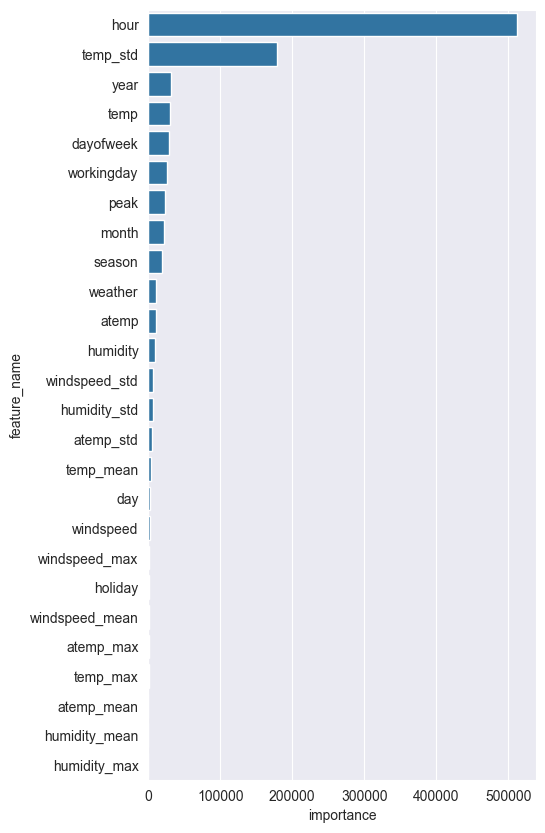

In [27]:
model = lgb.Booster(model_file=CONFIG.model_path / f"lgb_model_fold001.bin")
importance_df = pd.DataFrame()

importance_df["importance"] = model.feature_importance(importance_type="gain")
importance_df["feature_name"] = model.feature_name()
importance_df = importance_df.sort_values("importance", ascending=False)

fig = plt.figure(figsize=(5, 10))
sns.barplot(data=importance_df, x="importance", y="feature_name")
plt.show()

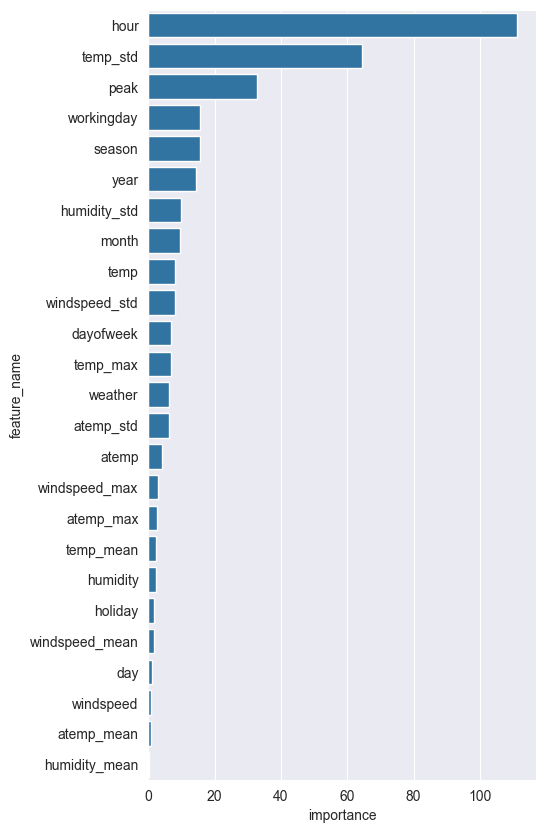

In [28]:
model = xgb.Booster(model_file=str(CONFIG.model_path / f"xgb_model_fold001.json"))
importance_df = pd.DataFrame()

importance_df["importance"] = model.get_score(importance_type="gain").values()
importance_df["feature_name"] = model.get_score(importance_type="gain").keys()
importance_df = importance_df.sort_values("importance", ascending=False)

fig = plt.figure(figsize=(5, 10))
sns.barplot(data=importance_df, x="importance", y="feature_name")
plt.show()

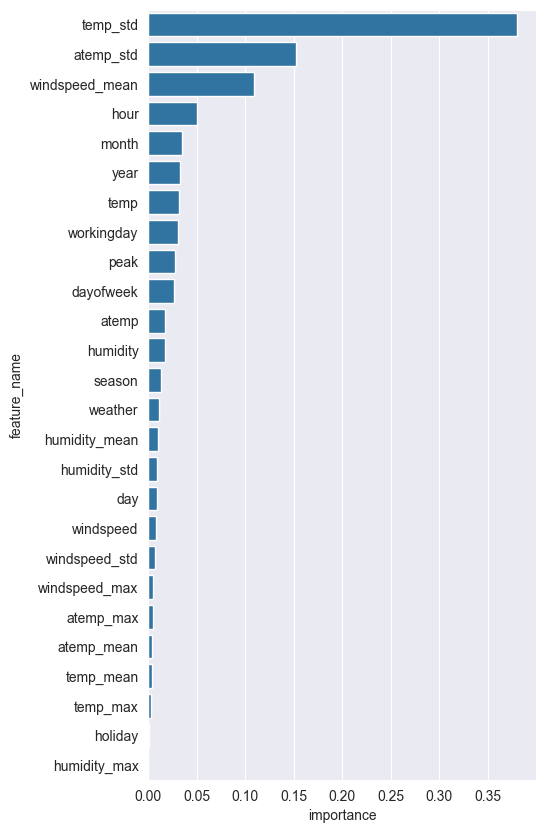

In [29]:
model_file_path = os.path.join(CONFIG.model_path, "rf_model_fold001.bin")
model = load(model_file_path)

importance_df = pd.DataFrame()
importance_df["importance"] = model.feature_importances_
importance_df["feature_name"] = test_df.columns
importance_df = importance_df.sort_values("importance", ascending=False)

fig = plt.figure(figsize=(5, 10))
sns.barplot(data=importance_df, x="importance", y="feature_name")
plt.show()